In [1]:
from sklearn import datasets
iris = datasets.load_iris(as_frame=True)

In [30]:
import pandas as pd
data = iris["frame"]
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [33]:
# Randomly split 30-70 test-train
import numpy as np

indices = np.arange(len(X))
np.random.shuffle(indices)

split = int(0.7 * len(X)) 
train_idx, test_idx = indices[:split], indices[split:]

train, test = data.iloc[train_idx], data.iloc[test_idx]

In [34]:
class0 = train[train["target"] == 0]
class1 = train[train["target"] == 1]
class2 = train[train["target"] == 2]
x_class0 = class0["sepal length (cm)"]
y_class0 = class0["petal length (cm)"]
x_class1 = class1["sepal length (cm)"]
y_class1 = class1["petal length (cm)"]
x_class2 = class2["sepal length (cm)"]
y_class2 = class2["petal length (cm)"]

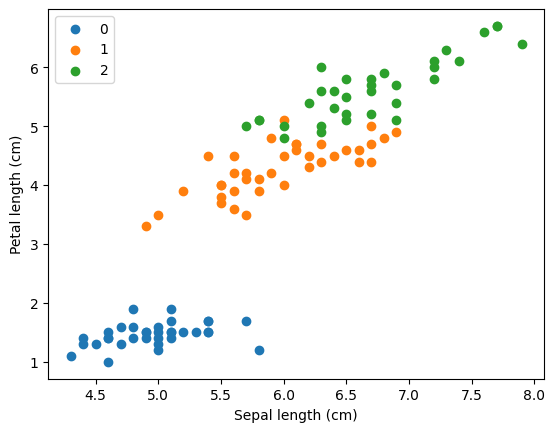

In [35]:
import matplotlib.pyplot as plt

plt.scatter(x_class0, y_class0, label="0")
plt.scatter(x_class1, y_class1, label="1")
plt.scatter(x_class2, y_class2, label="2")
plt.xlabel("Sepal length (cm)")
plt.ylabel("Petal length (cm)")
plt.legend()
plt.show()


In [36]:
class0_size = class0.shape[0]
class1_size = class1.shape[0]
class2_size = class2.shape[0]
total = class0_size + class1_size + class2_size
phis = [class0_size/total, class1_size/total, class2_size/total]
print(f"The probability of class 0: {phis[0]}")
print(f"The probability of class 1: {phis[1]}")
print(f"The probability of class 2: {phis[2]}")

The probability of class 0: 0.3238095238095238
The probability of class 1: 0.3619047619047619
The probability of class 2: 0.3142857142857143


In [39]:
import numpy as np
# Code adapted from HW3 code companion
X = train[["sepal length (cm)", "sepal width (cm)", "petal length (cm)",	"petal width (cm)"]]
d = 4 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(K):
    X_k = X[train["target"] == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)

# print out the means
print(mus)

[[4.95882353 3.37058824 1.46764706 0.25      ]
 [5.96315789 2.76315789 4.29210526 1.33684211]
 [6.6969697  3.01818182 5.62121212 2.05454545]]


In [45]:
# Return P(x|y)P(y) for given x
from scipy.stats import multivariate_normal
def get_highest_class(x):
    probs = []
    for k in range(K):
        p_y = phis[k]
        p_x_y = multivariate_normal.pdf(x, mean=mus[k], cov = Sigmas[k])
        probs.append(p_y*p_x_y)
    return probs.index(max(probs))

In [46]:
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
126,6.2,2.8,4.8,1.8,2
26,5.0,3.4,1.6,0.4,0
74,6.4,2.9,4.3,1.3,1
133,6.3,2.8,5.1,1.5,2
33,5.5,4.2,1.4,0.2,0


In [47]:
test["predictions"] = test.apply(get_highest_class, axis=1)

ValueError: operands could not be broadcast together with shapes (1,5) (4,) 